In [2]:
%load_ext autoreload
%autoreload 2
import requests
import os
import pandas as pd
import dgl.function as fn
import matplotlib.pyplot as plt

import numpy as np

# from modules.gnn import GNN
import scipy.sparse as sp
import numpy as np
import os

from modules.graph import Graph, create_files


import torch
import torch.nn.functional as F


/home/valentina/Desktop/GIT/TrabajoTesis/env310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Descargar archivo PeeringDB



Cada Sistema Autonomo registrado tendra la siguiente Informacion:

📋 Información general

    asn : Número de Sistema Autónomo
    name : Nombre corto de la red u organización.
    name_long : Nombre largo o completo de la organización.
    aka : Otros nombres por los que se conoce a la organización (alias).
    org_id : ID de la organización dentro de PeeringDB.
    website : Sitio web
    notes : Notas adicionales que la red ha dejado públicas.

🌐 Infraestructura de red

    fac_count : Número de datacenters (facilidades) donde opera.
    ix_count : Número de IXPs (puntos de intercambio de tráfico) en los que participa.
    netfac_updated : Fecha de última actualización de datos en facilidades.
    netixlan_updated : Fecha de última actualización de datos en IXPs.

🔄 Políticas de peering

    policy_general : Política de peering: puede ser {'Open', '', 'Selective', 'No', 'Restrictive'}.
    policy_ratio : Ratio de tráfico que influye en si se acepta peering {False, True}.
    policy_locations : Lugares donde aplica la política de peering. {'', 'Required - US', 'Preferred', 'Required - EU', 'Required - International', 'Not Required'}
    policy_contracts : Si se requiere contrato para establecer peering. {'', 'Private Only', 'Not Required', 'Required'}
    policy_url : URL pública donde se detalla la política de peering.

📶 Capacidad y tipo de tráfico

    info_prefixes4 : Cantidad de prefijos IPv4 que anuncia la red.

    info_prefixes6 : Cantidad de prefijos IPv6 que anuncia la red.

    info_traffic : Nivel estimado de tráfico (ej: 100-200Gbps, 20Gbps, etc.).Unique values in : {'', '100-200Gbps', '10-20Tbps', '100-1000Mbps', '50-100Gbps', '500-1000Gbps', '50-100Tbps', '100+Tbps', '5-10Gbps', '200-300Gbps', '0-20Mbps', '20-50Tbps', '1-5Gbps', '20-50Gbps', '1-5Tbps', '300-500Gbps', '5-10Tbps', '20-100Mbps', '10-20Gbps'}

    info_unicast : Si soporta tráfico unicast (la mayoría sí). {False, True}

    info_multicast : Si soporta tráfico multicast. {False, True}

    info_ipv6 : Si soporta tráfico IPv6. {False, True}

    info_scope : Alcance de la red: puede ser "Global", "Regional", "National", etc. Unique values in : {'', 'Not Disclosed', 'Asia Pacific', 'Europe', 'Regional', 'Middle East', 'North America', 'Africa', 'Global', 'South America', 'Australia'}

    info_type : Tipo de red: "NSP" (network service provider), "Content", "Enterprise", etc. Unique values in : {'', 'Content', 'Enterprise', 'Not Disclosed', 'Route Server', 'Educational/Research', 'Government', 'Non-Profit', 'Network Services', 'Cable/DSL/ISP', 'NSP', 'Route Collector'}

    info_never_via_route_servers : Indica si no acepta rutas a través de route servers.

    info_ratio : {'', 'Balanced', 'Not Disclosed', 'Mostly Inbound', 'Mostly Outbound', 'Heavy Inbound', 'Heavy Outbound'} 🔍 Monitoreo y herramientas

    route_server

    looking_glass : URL de su looking glass (para ver rutas que anuncia o recibe).

    status_dashboard : Página donde publica el estado de su red (caídas, mantenimientos, etc.).

📅 Tiempos y actualizaciones

    created : Fecha de creación del registro en PeeringDB.
    updated : Última fecha de actualización del registro general.
    poc_updated : Última vez que se actualizaron los contactos (Points of Contact).
    id :
    allow_ixp_update : Indica si los IXPs pueden actualizar la información de esta red.
    irr_as_set : Set de objetos IRR (Internet Routing Registry) usados para filtrado de rutas.





In [3]:
def dowload_peeringdb(year:str='2022',month:str='01',day:str='01'):
    """
    Download the latest PeeringDB data from the official website.
    """

    # URL de descarga de PeeringDB data en caida
    url = f"https://publicdata.caida.org/datasets/peeringdb/{year}/{month}/peeringdb_2_dump_{year}_{month}_{day}.json"

    # Carpeta donde se guarda el archivo
    file_path = os.path.join('data/peeringdb', "peeringdb.json")

    # Descargar el archivo
    try:
        response = requests.get(url)
    except:
        print(f"Error downloading PeeringDB data: {e}")
        return

    with open(file_path, "wb") as file:
        file.write(response.content)

    print(f"Downloaded PeeringDB data to {file_path}")

In [4]:
year = '2022'
month = '07'
day = '01'

dowload_peeringdb(year, month, day)



Downloaded PeeringDB data to data/peeringdb/peeringdb.json


In [5]:
import json

peeringdb_file = 'data/peeringdb/peeringdb.json'
with open(peeringdb_file) as f:
    data = json.load(f)['net']['data']
    first_as = data[0]
    print(first_as.keys())



dict_keys(['status', 'looking_glass', 'route_server', 'netixlan_updated', 'info_ratio', 'id', 'policy_locations', 'policy_ratio', 'status_dashboard', 'info_unicast', 'created', 'name_long', 'policy_general', 'website', 'allow_ixp_update', 'updated', 'netfac_updated', 'info_traffic', 'info_multicast', 'asn', 'info_prefixes4', 'name', 'info_scope', 'notes', 'ix_count', 'org_id', 'policy_url', 'info_never_via_route_servers', 'poc_updated', 'info_type', 'policy_contracts', 'info_prefixes6', 'aka', 'fac_count', 'info_ipv6', 'irr_as_set'])




Creo un diccionario con cada atributos que me indique Si el atributo es :

    Categorico o numerico
    Si es categorico se transforma en un one-hot vector



In [6]:
# Listas con los nombres de los atributos que nos interesan
num_list = ['ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']

# Lista combinada de todos los atributos
list_all = num_list + categorical_list + boolean_list

# Inicializo un diccionario vacío
dict_attr = {}

# Recorrer cada atributo de la lista
for attr in list_all:
    # Asegurarse de que cada atributo tenga un diccionario inicializado
    if attr not in dict_attr:
        dict_attr[attr] = {}

    # Determinar si es numérico o no y agregarlo al diccionario
    if attr in num_list:
        dict_attr[attr]['categorical'] = False
    else:
        dict_attr[attr]['categorical'] = True

    # Set para los valores únicos
    uniques = set()
    count_empty = 0  # Inicializo el contador de valores vacíos

    # Iterar sobre los datos de 'data'
    for asn in data:
        value = asn.get(attr)  # Usar .get() para manejar posibles claves faltantes

        # Contar valores vacíos
        if value == '' or value is None:
            count_empty += 1

        # Agregar el valor al set de valores únicos
        uniques.add(value)

    # Guardar el número de valores únicos
    dict_attr[attr]['uniques'] = len(uniques)
    dict_attr[attr]['empty_count'] = count_empty  # Guardar el conteo de valores vacíos si es necesario

# Mostrar el diccionario resultante
for key, value in dict_attr.items():
    print(f"{key}: {value}")



ix_count: {'categorical': False, 'uniques': 83, 'empty_count': 0}
fac_count: {'categorical': False, 'uniques': 91, 'empty_count': 0}
info_prefixes4: {'categorical': False, 'uniques': 364, 'empty_count': 0}
info_prefixes6: {'categorical': False, 'uniques': 188, 'empty_count': 0}
policy_general: {'categorical': True, 'uniques': 5, 'empty_count': 1080}
policy_locations: {'categorical': True, 'uniques': 6, 'empty_count': 1080}
policy_contracts: {'categorical': True, 'uniques': 4, 'empty_count': 1212}
info_traffic: {'categorical': True, 'uniques': 19, 'empty_count': 10217}
info_scope: {'categorical': True, 'uniques': 11, 'empty_count': 257}
info_type: {'categorical': True, 'uniques': 12, 'empty_count': 336}
info_ratio: {'categorical': True, 'uniques': 7, 'empty_count': 492}
policy_ratio: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_unicast: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_multicast: {'categorical': True, 'uniques': 2, 'empty_count': 0}
info_ipv6: {'c

## Atributos Numericos



In [7]:
num_list = ['asn', 'ix_count', 'fac_count', 'info_prefixes4', 'info_prefixes6']


# Crear DataFrame con los datos numéricos
num_data = {attr: [asn.get(attr, None) for asn in data] for attr in num_list}
num_df = pd.DataFrame(num_data)

# Logarithmic transformation to decrease their variability,
num_df[num_list[1:]] = num_df[num_list[1:]].astype(float)
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: np.log(x + 1))

# Normalization
num_df[num_list[1:]] = num_df[num_list[1:]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

num_df

,asn,ix_count,fac_count,info_prefixes4,info_prefixes6
0,4436,0.000000,0.000000,0.883505,0.772792
1,20940,0.925620,0.778091,0.679870,0.714642
2,31800,0.489601,0.000000,0.100343,0.000000
3,22822,0.802283,0.645658,0.616509,0.521597
4,3303,0.707639,0.526179,0.666674,0.628952
...,...,...,...,...,...
25268,149835,0.000000,0.000000,0.000000,0.288125
25269,1025,0.000000,0.000000,0.000000,0.000000
25270,137113,0.000000,0.000000,0.268797,0.368711
25271,269626,0.000000,0.000000,0.000000,0.000000


In [8]:

for colum in num_df.columns:
    min = num_df[colum].min()
    max = num_df[colum].max()
    print(f"Columna: {colum} Min: {min} Max: {max}") 

Columna: asn Min: 3 Max: 401308
Columna: ix_count Min: 0.0 Max: 1.0
Columna: fac_count Min: 0.0 Max: 1.0
Columna: info_prefixes4 Min: 0.0 Max: 1.0
Columna: info_prefixes6 Min: 0.0 Max: 1.0


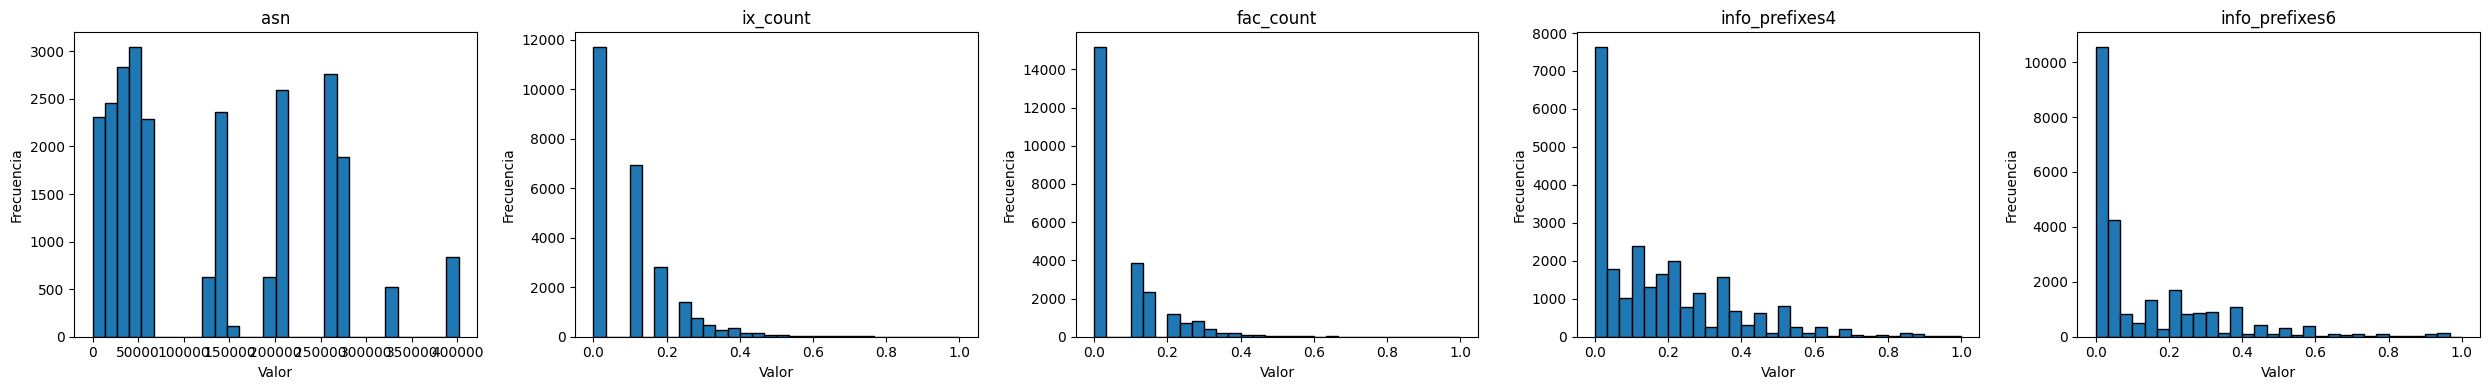

In [9]:


# Ahora graficamos usando subplots
num_cols = len(num_df.columns)  # cantidad de columnas
fig, axs = plt.subplots(1, num_cols, figsize=(5*num_cols, 4))  # 1 fila, varias columnas

# Si hay solo 1 columna, axs no es una lista, así que lo forzamos a lista
if num_cols == 1:
    axs = [axs]

for i, col in enumerate(num_df.columns):
    axs[i].hist(num_df[col], bins=30, edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()




## Atributos Categoricos

In [10]:
categorical_list = ['policy_general', 'policy_locations', 'policy_contracts', 'info_traffic', 'info_scope', 'info_type', 'info_ratio']


# Listas de atributos
boolean_list = ['policy_ratio', 'info_unicast', 'info_multicast', 'info_ipv6', 'info_never_via_route_servers']
list_all = num_list + categorical_list + boolean_list


# Crear DataFrame con los datos categóricos y hacer one-hot encoding
cat_data = {attr: [asn.get(attr, None) for asn in data] for attr in categorical_list}
cat_df = pd.DataFrame(cat_data)

# Realizar One-Hot Encoding para los atributos categóricos
cat_df_encoded = pd.get_dummies(cat_df, columns=categorical_list, prefix=categorical_list,dtype=int)
cat_df_encoded


,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,policy_locations_,policy_locations_Not Required,policy_locations_Preferred,policy_locations_Required - EU,policy_locations_Required - International,...,info_type_Not Disclosed,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25268,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
25269,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
25270,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25271,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [11]:
for attr in categorical_list:
    unique_vals = cat_df[attr].unique()
    print(f"Atributo: {attr}")
    print(f"Categorías únicas ({len(unique_vals)}): {unique_vals}\n")


Atributo: policy_general
Categorías únicas (5): ['Restrictive' 'Open' 'Selective' 'No' '']

Atributo: policy_locations
Categorías únicas (6): ['Required - International' 'Not Required' 'Preferred' 'Required - US'
 'Required - EU' '']

Atributo: policy_contracts
Categorías únicas (4): ['Required' 'Not Required' 'Private Only' '']

Atributo: info_traffic
Categorías únicas (19): ['' '100+Tbps' '100-1000Mbps' '10-20Tbps' '1-5Tbps' '100-200Gbps'
 '50-100Gbps' '500-1000Gbps' '20-50Gbps' '0-20Mbps' '1-5Gbps' '5-10Tbps'
 '10-20Gbps' '300-500Gbps' '20-100Mbps' '5-10Gbps' '200-300Gbps'
 '50-100Tbps' '20-50Tbps']

Atributo: info_scope
Categorías únicas (11): ['Global' 'Europe' 'North America' 'Regional' '' 'Asia Pacific'
 'South America' 'Not Disclosed' 'Australia' 'Africa' 'Middle East']

Atributo: info_type
Categorías únicas (12): ['NSP' 'Content' 'Non-Profit' 'Cable/DSL/ISP' '' 'Enterprise'
 'Educational/Research' 'Route Server' 'Route Collector' 'Not Disclosed'
 'Network Services' 'Government

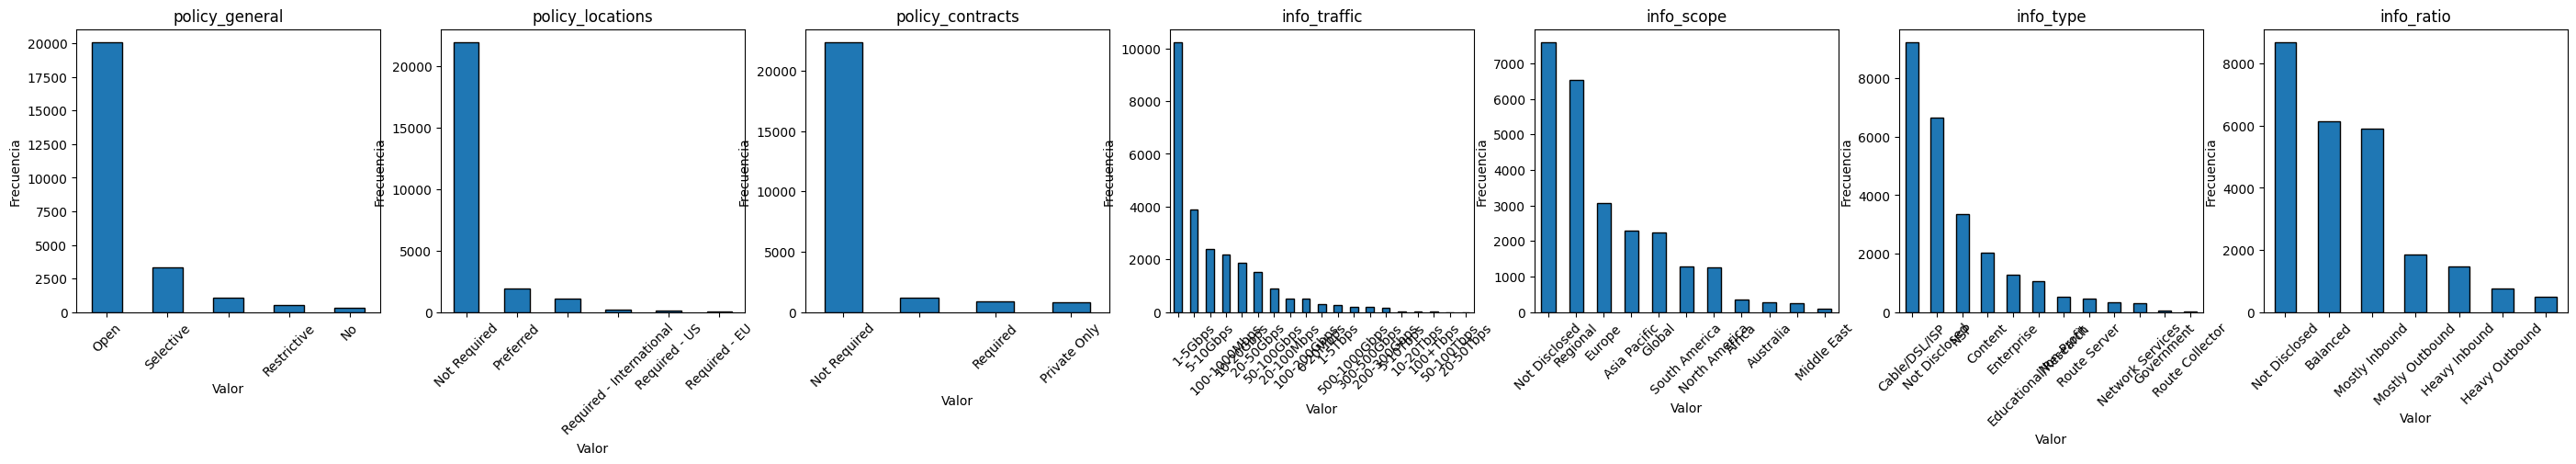

In [12]:


# Ahora graficamos usando subplots
num_cols = len(categorical_list)  # cantidad de columnas
fig, axs = plt.subplots(1, num_cols, figsize=(5*num_cols, 4))

# Para cada atributo y su correspondiente subplot
for i, attr in enumerate(categorical_list):
    value_counts = cat_df[attr].value_counts()
    
    value_counts.plot(kind='bar', ax=axs[i], edgecolor='black')
    axs[i].set_title(attr)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)





## Juntar DF 

    categorico
    Numerico


In [13]:


# Concatenar todos los DataFrames (numéricos, categóricos y booleanos)
final_df = pd.concat([num_df, cat_df_encoded], axis=1)

final_df.sort_values(by='asn')



,asn,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Not Disclosed,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
4143,3,0.0000,0.165327,0.173565,0.058158,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
10001,4,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
13817,6,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
22611,7,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
12032,8,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24817,400705,0.0000,0.000000,0.079520,0.201193,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
24889,400721,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
25029,400735,0.1224,0.104310,0.116495,0.058158,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
23248,401307,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [14]:



final_df[final_df.select_dtypes('bool').columns] = final_df.select_dtypes('bool').astype(int)
final_df = final_df.rename(columns={'asn': 'ASN'})


final_df = final_df.sort_values(by='ASN', ascending=True)



In [15]:


print(final_df.shape)
final_df.tail(2)



(25273, 69)


,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Not Disclosed,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed
23248,401307,0.0,0.0,0.000000,0.000000,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
22879,401308,0.0,0.0,0.050172,0.058158,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:


# Contar el número de columnas
num_columns = final_df.shape[1]

# Mostrar el número de columnas
print(f'Número de columnas: {num_columns}')



Número de columnas: 69


In [17]:
# Guardar el DataFrame final en un archivo CSV
import pandas as pd

final_df.to_csv('data/node_features_mio.csv', index=False)

## agregar attr page Rank

In [18]:


# Creacion grafo:

import torch
import dgl
from modules.gnn import GNN


# Definimos las rutas de los archivos
base_path = os.getcwd() + "/data/"
relationships_file = base_path + f"CAIDA_AS_Relationships/Serial_1/{year}{month}{day}.as-rel.txt.bz2"
features_file = base_path + "/node_features.csv"
rib_path = base_path + 'sanitized_rib.txt'
dataset_graph_path = base_path + 'dgl_graph/'



In [19]:
gnn = GNN(debug=True)
gnn.load_dataset(dataset_graph_path, force_reload=True)

print('[ATTR SHAPE]: ',gnn.dgl_graph.ndata['feat'].shape)

Done saving data into cached files.
Graph(num_nodes=43183, num_edges=133091,
      ndata_schemes={'feat': Scheme(shape=(68,), dtype=torch.float32)}
      edata_schemes={'Relationship': Scheme(shape=(), dtype=torch.float32)})
[ATTR SHAPE]:  torch.Size([43183, 68])


In [20]:


# ----------- Run PageRank for Graph -------------- #
N = gnn.dgl_graph.number_of_nodes()

DAMP = 0.85
K = 10

def compute_pagerank(g):
    g.ndata["pv"] = torch.ones(N) / N
    degrees = g.out_degrees(g.nodes()).type(torch.float32)
    for k in range(K):
        g.ndata["pv"] = g.ndata["pv"] / degrees
        g.update_all(
            message_func=fn.copy_u(u="pv", out="m"),
            reduce_func=fn.sum(msg="m", out="pv"),
        )
        g.ndata["pv"]  = (1 - DAMP) / N + DAMP * g.ndata["pv"]
    g.ndata["pv"]  = g.ndata["pv"].unsqueeze(1)
    return g.ndata["pv"]


pv = compute_pagerank(gnn.dgl_graph)
gnn.dgl_graph.ndata["h"] = pv  # Inicializa características del nodo

print(gnn.dgl_graph.ndata["h"])



tensor([[2.2628e-05],
        [1.6470e-05],
        [2.4232e-05],
        ...,
        [3.4736e-06],
        [3.6272e-06],
        [3.4736e-06]])


In [21]:


# Obtenemos serie de ASN del df

pr_values = []
for asn in final_df['ASN']:
    try:
        pr_values.append(gnn.dgl_graph.ndata['h'][asn].item()) 
    except:
        pr_values.append(0) # FIXME: Revissar

len(pr_values)



25273

In [22]:
# Normlaizamos los valores de PageRank
pr_values = np.array(pr_values)  

pr_min = pr_values.min()
pr_max = pr_values.max()

pagerank_norm = (pr_values - pr_min) / (pr_max - pr_min)

final_df['PageRank'] = pr_values

In [23]:
final_df

,ASN,ix_count,fac_count,info_prefixes4,info_prefixes6,policy_general_,policy_general_No,policy_general_Open,policy_general_Restrictive,policy_general_Selective,...,info_type_Route Collector,info_type_Route Server,info_ratio_,info_ratio_Balanced,info_ratio_Heavy Inbound,info_ratio_Heavy Outbound,info_ratio_Mostly Inbound,info_ratio_Mostly Outbound,info_ratio_Not Disclosed,PageRank
4143,3,0.0000,0.165327,0.173565,0.058158,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.000023
10001,4,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000012
13817,6,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000003
22611,7,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000013
12032,8,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24817,400705,0.0000,0.000000,0.079520,0.201193,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0.000000
24889,400721,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000000
25029,400735,0.1224,0.104310,0.116495,0.058158,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.000000
23248,401307,0.0000,0.000000,0.000000,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0.000000


In [24]:
final_df.to_csv('data/node_features_mio.csv', index=False)

In [25]:
final_df['PageRank'].max()

6.763896089978516e-05

In [26]:
final_df['PageRank'].max()
final_df['PageRank'].min()

0.0